# Setup, Constants, and Imports

In [8]:
import os
import sys
import logging

## Notebook Configs

In [9]:
IS_COLAB = 'google.colab' in sys.modules
OUTPUT_PROCESSED_FILES = True # TODO: Use this if you want to output save files (optional - see below)

if IS_COLAB:
    from google.colab import userdata
    GITHUB_USERNAME = userdata.get('github_user')
    GITHUB_TOKEN = userdata.get('github_token')
    GITHUB_EMAIL = userdata.get('github_email')

## Constants

In [10]:
REPO_URL = "https://github.com/EErlando/Quarterly-Bytes.git"
REPO_NAME = "src"
REPO_BRANCH = "main" # TODO: UPDATE THIS TO YOU BRANCH - DEFAULT TO MAIN
ALL_TRANSCRIPTS_PATH = "data/raw/JP Morgan/Transcripts"
NOTEBOOK_DIR = "notebooks" # TODO: UPDATE THIS TO YOUR NOTEBOOK DIRECTORY (e.g. 1_data_extraction_and_processing)

## Clone and Pull Latest from Repository - Colab Specific

In [11]:
if IS_COLAB:
    !git config pull.rebase false
    if os.path.exists(REPO_NAME):
        print(f"Directory '{REPO_NAME}' already exists. Pulling latest changes...")
        %cd {REPO_NAME}
        !git pull origin {REPO_BRANCH} --quiet
        %cd ..
    else:
        print(f"Cloning repository into '{REPO_NAME}'...")
        !git clone --quiet --branch {REPO_BRANCH} {REPO_URL} {REPO_NAME}
        print("Clone complete.")

    sys.path.append('/content/src/')
    %cd /content/src/
    !pip install -r requirements.txt
else:
    !pip install -r requirements.txt
    if os.path.basename(os.getcwd()) == NOTEBOOK_DIR:
        os.chdir('../') # TODO: UPDATE THIS TO ROOT OF REPO

logging.basicConfig(level=logging.ERROR, format='%(levelname)s: %(message)s')

Directory 'src' already exists. Pulling latest changes...
/content/src/src
/content/src
/content/src


In [12]:
import nltk
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import seaborn as sns
import re

In [13]:
jp_morgan_md_df = pd.read_csv('/content/src/data/processed/JP Morgan/qna_df.csv')
display(jp_morgan_md_df.head())


,question_order,question_answer_group_id,speaker,role,company,content,year,quarter
0,0,0,John E. McDonald,Analyst,Autonomous Research,"Thank you. Morning, Jeremy. Was wondering abou...",2022,1
1,1,0,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Good morning, John. Good question. Yeah, look,...",2022,1
2,2,0,John E. McDonald,Analyst,Autonomous Research,"Okay. And as my follow up, could you give us s...",2022,1
3,3,0,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,Yeah. I guess I would direct you to my comment...,2022,1
4,4,0,John E. McDonald,Analyst,Autonomous Research,Okay. Thanks.,2022,1


In [15]:
# Grouping content by question_answer_group_id
grouped_df = jp_morgan_md_df.groupby('question_answer_group_id')['content'].apply(' '.join).reset_index()

# Display grouped data for verification
print(grouped_df.head())

   question_answer_group_id                                            content
0                         0  Thank you. Morning, Jeremy. Was wondering abou...
1                         1  ...if you're on –  yeah. Thank you. Good morni...
2                         2  Good morning. I guess just a coupl e of follow...


In [17]:
!pip install sumy

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 63.3 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21693 sha256=b3ae01ded47d6139d014b469bdc329dd1670ff5a6ef622dc6a7a1b4d93c9109d
  Stored in directory: /root/.cache/pip/wheels/4d/57/58/7e3d7fedf51fe248b7fcee3df6945ae28638e22cddf01eb92b
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=4c6516ac4346dfef660c2608a70f3227c0bddcd56c362c5b9cd02bc692f223ca
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built breadability docopt


## Simple Extractive Models (Baseline)

In [32]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
import nltk
nltk.download('punkt_tab')

# Define a summarization function
def summarize_text(text, num_sentences=2):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, num_sentences)
    return ' '.join([str(sentence) for sentence in summary])

# Apply summarization to the grouped DataFrame
grouped_df['summary'] = grouped_df['content'].apply(lambda x: summarize_text(x, num_sentences=3))

# Verify summaries
print(grouped_df[['question_answer_group_id', 'summary']].head())


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


   question_answer_group_id                                            summary
0                         0  So then if you line that up against the sort o...
1                         1  But I think more broadly on be nchmarking ours...
2                         2  So I think, yeah, you're referring to my comme...


In [33]:
grouped_df.to_csv('qa_grouped_with_summaries.csv', index=False)

In [34]:
# Add word count columns
grouped_df['orig_length'] = grouped_df['content'].apply(lambda x: len(x.split()))
grouped_df['summary_length'] = grouped_df['summary'].apply(lambda x: len(x.split()))

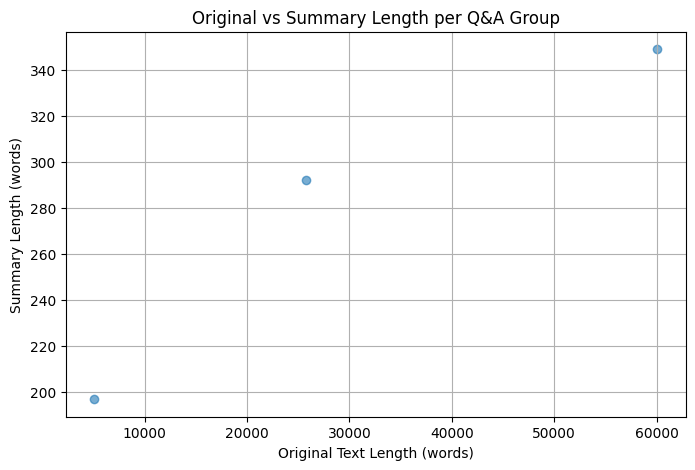

In [35]:
# Plot Original vs Summary Length

plt.figure(figsize=(8,5))
plt.scatter(grouped_df['orig_length'], grouped_df['summary_length'], alpha=0.6)
plt.xlabel('Original Text Length (words)')
plt.ylabel('Summary Length (words)')
plt.title('Original vs Summary Length per Q&A Group')
plt.grid(True)
plt.show()


In [36]:
print(grouped_df[['question_answer_group_id', 'orig_length', 'summary_length']])


   question_answer_group_id  orig_length  summary_length
0                         0        60088             349
1                         1        25795             292
2                         2         5033             197


In [37]:
longest = grouped_df.loc[grouped_df['summary_length'].idxmax()]
print("Longest Summary Q&A Group:", longest['question_answer_group_id'])
print("Summary Length:", longest['summary_length'])
print("Summary Text:", longest['summary'])

shortest = grouped_df.loc[grouped_df['summary_length'].idxmin()]
print("\nShortest Summary Q&A Group:", shortest['question_answer_group_id'])
print("Summary Length:", shortest['summary_length'])
print("Summary Text:", shortest['summary'])


Longest Summary Q&A Group: 0
Summary Length: 349
Summary Text: So then if you line that up against the sort of rising minimums, of course, we have the increase in the GSIB requirement in t he first quarter of 2023 com ing in and then there's the question of SCB where we don't know obviously, but given the countercyclical nature of the stress  and the fact that the unemployment launch point is a lot lower and the unemployment rate is floored in the Fed's scenario, you mig ht expect SCB to be a little bit higher when it's published in June effective in the fourth quarter. And I think that last point of Jamie's is particularly important because, sure, if you want, you can construct what I would c onsider a very optimistic argument that the higher cost of doing business will lead smaller scale players to exit and that's a shar e gain opportunity for us, but if I refer back to the comments about the disincentives to beneficial diversification and scale, getting bigger, especially i n market

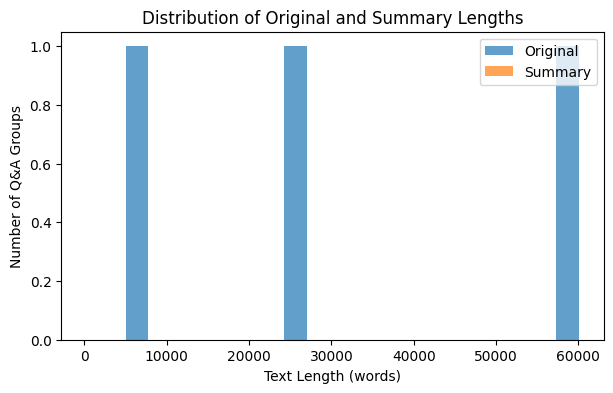

In [38]:
plt.figure(figsize=(7,4))
plt.hist(grouped_df['orig_length'], bins=20, alpha=0.7, label='Original')
plt.hist(grouped_df['summary_length'], bins=20, alpha=0.7, label='Summary')
plt.xlabel('Text Length (words)')
plt.ylabel('Number of Q&A Groups')
plt.title('Distribution of Original and Summary Lengths')
plt.legend()
plt.show()


In [39]:
# Find Q&A group with the longest summary
longest = grouped_df.loc[grouped_df['summary_length'].idxmax()]
print("Longest Summary Q&A Group:")
print(longest[['question_answer_group_id', 'summary_length', 'summary']])

# Find Q&A group with the shortest summary
shortest = grouped_df.loc[grouped_df['summary_length'].idxmin()]
print("\nShortest Summary Q&A Group:")
print(shortest[['question_answer_group_id', 'summary_length', 'summary']])


Longest Summary Q&A Group:
question_answer_group_id                                                    0
summary_length                                                            349
summary                     So then if you line that up against the sort o...
Name: 0, dtype: object

Shortest Summary Q&A Group:
question_answer_group_id                                                    2
summary_length                                                            197
summary                     So I think, yeah, you're referring to my comme...
Name: 2, dtype: object


## Summary of Findings from Plots and Analysis basedon num_sentences=2

1. Scatter Plot: Original vs Summary Length.

The scatter plot showed just a few points, each far below the 1:1 line. All summary points clustered near the bottom, while originals varied widely along the X-axis.

What it means:

Original Q&A groups varied greatly in length—some were long, some short.

Summaries were much shorter (as expected) and had very similar lengths (due to extracting a fixed number of sentences).

TextRank consistently compresses Q&A groups to a similar, much smaller size, regardless of how long the original was.

2. Histogram: Distribution of Text Lengths.

Originals spread out with some much longer than others (right-skewed).

Summaries mostly stacked in a single bin/bar, barely visible compared to originals.

What it means:

Most original Q&A sessions were relatively short, but a few were very long.

Summaries had little length variation—all ended up in the same small range, since each summary was always 3 sentences.

This shows TextRank extractive summaries are not sensitive to input length—the number of sentences is fixed, so the reduction is more dramatic for longer originals.

3. Longest vs Shortest Summary

The longest and shortest summaries (by word count) differed only slightly.

What it means:

Summaries do not scale with content: Long Q&A groups don’t get longer summaries—TextRank just picks the top N sentences, no matter what.

## Overall Insights
Dataset had only a handful of Q&A groups after filtering (for one company and one role).

Extractive summarization (TextRank) works well for drastically reducing text size, but using a fixed number of sentences means it can under-summarize long exchanges and over-summarize very short ones.

Summaries are highly compressed and uniform, so they may not always reflect the nuance or full coverage of the longer Q&A.

Visualizations confirm:

High original length variability,

Low summary length variability,

Strong, consistent “compression” regardless of input length.

## Takeaways
Extractive methods are useful for fast, uniform reduction, but may not adapt well to Q&A sessions of very different sizes.

Transformer-based abstractive summarization (follows below) should produce summaries that are more sensitive to content and context, and might be more readable and informative.



## Abstractive Summarization with Transformers

- T5
- BART

In [40]:
!pip install transformers sentencepiece

In [41]:
from transformers import pipeline

# T5 summarization

summarizer = pipeline("summarization", model="t5-small", tokenizer="t5-small")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cpu


In [42]:
# You can limit to first 512 tokens for longer content
def abstractive_summary(text, max_length=60, min_length=15):
    # Optional: Truncate input for very long groups
    if len(text.split()) > 500:
        text = ' '.join(text.split()[:500])
    # Add "summarize:" prefix for T5
    input_text = "summarize: " + text
    summary = summarizer(input_text, max_length=max_length, min_length=min_length, do_sample=False)
    return summary[0]['summary_text']

# Apply to your grouped_df (may take a while if many rows!)
grouped_df['t5_summary'] = grouped_df['content'].apply(abstractive_summary)


Token indices sequence length is longer than the specified maximum sequence length for this model (676 > 512). Running this sequence through the model will result in indexing errors
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


In [43]:
for idx, row in grouped_df.head(3).iterrows():
    print(f"\nQ&A Group {row['question_answer_group_id']}")
    print("Original:\n", row['content'][:350], "...")
    print("TextRank Summary:\n", row['summary'])
    print("T5 Abstractive Summary:\n", row['t5_summary'])



Q&A Group 0
Original:
 Thank you. Morning, Jeremy. Was wondering about the net interest income outlook, I know it sounds like we'll get more at Inve stor Day, but
it's very similar to what you gave in mid-February and obviously rate expectations have advanced since then. Could you give us a little bit of
color and what kind of assumptions are underlying the net interest  ...
TextRank Summary:
 So then if you line that up against the sort of rising minimums, of course, we have the increase in the GSIB requirement in t he first quarter of 2023 com ing in and then there's the question of SCB where we don't know obviously, but given the countercyclical nature of the stress  and the fact that the unemployment launch point is a lot lower and the unemployment rate is floored in the Fed's scenario, you mig ht expect SCB to be a little bit higher when it's published in June effective in the fourth quarter. And I think that last point of Jamie's is particularly important because, sure, if you w

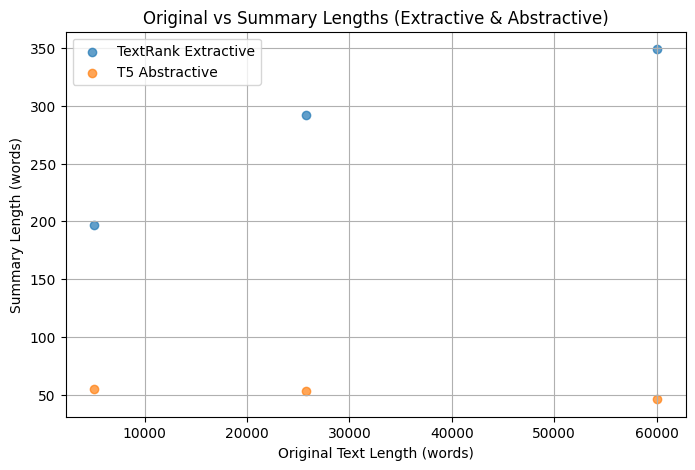

In [45]:
grouped_df['t5_summary_length'] = grouped_df['t5_summary'].apply(lambda x: len(x.split()))

# plot
plt.figure(figsize=(8,5))
plt.scatter(grouped_df['orig_length'], grouped_df['summary_length'], alpha=0.7, label='TextRank Extractive')
plt.scatter(grouped_df['orig_length'], grouped_df['t5_summary_length'], alpha=0.7, label='T5 Abstractive')
plt.xlabel('Original Text Length (words)')
plt.ylabel('Summary Length (words)')
plt.title('Original vs Summary Lengths (Extractive & Abstractive)')
plt.legend()
plt.grid(True)
plt.show()


Interpretation

- TextRank Extractive:

Summary lengths are much higher (around 200–350 words), even though we only asked for 3 sentences.

That’s because the original Q&A sentences are often long, so "3 sentences" can still mean a long summary if the originals are verbose.

Takeaway: Extractive methods do not control for summary length in words—only by sentence count.

- T5 Abstractive:

Summary lengths are much shorter (about 45–55 words), and consistent across all Q&A groups, regardless of the original length.


- All Q&A groups:

Both methods reduce text length dramatically compared to the original.

The gap between extractive and abstractive summaries increases as the original gets longer—abstractive models "shrink" more.

What Does This Mean for Your Data?
TextRank Extractive gives you snippets directly from the text; summary size depends on the length of those sentences.

T5 Abstractive gives you compact, rephrased summaries with much tighter length control.

For very long Q&A sessions, abstractive summaries will be much easier to read and scan for key points.

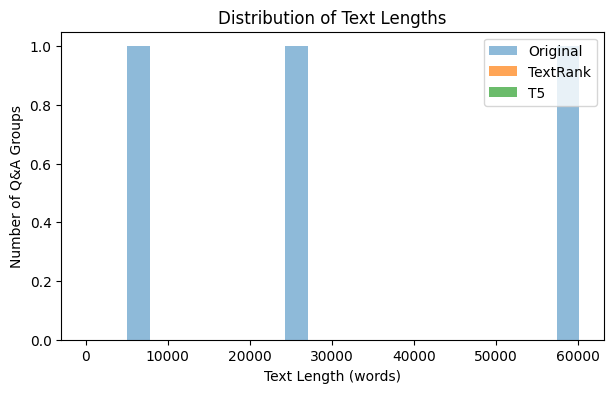

In [46]:
plt.figure(figsize=(7,4))
plt.hist(grouped_df['orig_length'], bins=20, alpha=0.5, label='Original')
plt.hist(grouped_df['summary_length'], bins=20, alpha=0.7, label='TextRank')
plt.hist(grouped_df['t5_summary_length'], bins=20, alpha=0.7, label='T5')
plt.xlabel('Text Length (words)')
plt.ylabel('Number of Q&A Groups')
plt.title('Distribution of Text Lengths')
plt.legend()
plt.show()


Interpretation

- Extreme Compression:

Both extractive and abstractive models dramatically reduce the size of the text, by 100x or more for these large Q&A groups.

- Uniformity:

TextRank (fixed number of sentences) and T5 (controlled summary length) both create very consistent summary lengths.

This uniformity is why the histogram for summaries is almost a single bin.


Conclusion


Summarization is effective—the original Q&A text is massively compressed.

With only a few data points and extreme length disparity, plots are dominated by the original text bins.

TextRank and T5 produce short, readable summaries, ideal for executive overview even of very long Q&A sessions.

In [50]:
# Print side-by-side samples for the first 3 Q&A groups
for idx, row in grouped_df.head(3).iterrows():
    print(f"\n=== Q&A Group {row['question_answer_group_id']} ===")
    print("Original (first 300 chars):")
    print(row['content'][:300] + " ...")
    print("\nTextRank Extractive Summary:")
    print(row['summary'])
    print("\nT5 Abstractive Summary:")
    print(row['t5_summary'])
    print("="*60)



=== Q&A Group 0 ===
Original (first 300 chars):
Thank you. Morning, Jeremy. Was wondering about the net interest income outlook, I know it sounds like we'll get more at Inve stor Day, but
it's very similar to what you gave in mid-February and obviously rate expectations have advanced since then. Could you give us a little bit of
color and what ki ...

TextRank Extractive Summary:
So then if you line that up against the sort of rising minimums, of course, we have the increase in the GSIB requirement in t he first quarter of 2023 com ing in and then there's the question of SCB where we don't know obviously, but given the countercyclical nature of the stress  and the fact that the unemployment launch point is a lot lower and the unemployment rate is floored in the Fed's scenario, you mig ht expect SCB to be a little bit higher when it's published in June effective in the fourth quarter. And I think that last point of Jamie's is particularly important because, sure, if you want, you can c

- TextRank Extractive Summaries
Long, complex sentences—directly copied from the original transcript.

Sometimes these are hard to follow and may include irrelevant details or run-on sentences.

For example, Group 0’s summary is nearly a paragraph of complex, nested thoughts with no condensation.

- T5 Abstractive Summaries
Short, clear, and much more concise.

Rephrased: not just copying, but interpreting and compressing the content.

Focuses on the core idea or takeaway, even if it omits some nuance or detail.

For instance, in Group 0: “i think we'll see a headwind in there as the Fed hikes come through...” is an interpretation of a much larger discussion.

Key Insights:

Abstractive summaries (T5) are far more digestible for quick review or executive consumption.

Extractive summaries (TextRank) might be useful for compliance or audit purposes (since they use actual transcript sentences), but they are less readable for humans who want a gist.

T5 summaries can “miss” nuance if the original is highly technical, but for most Q&A, they are much more practical.

In [51]:

# BART summarization model
bart_summarizer = pipeline("summarization", model="facebook/bart-large-cnn")


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


In [52]:
def bart_abstractive_summary(text, max_length=60, min_length=15):
    # Truncate if needed for BART's max length (optional, here ~700 words as a rough safety)
    if len(text.split()) > 700:
        text = ' '.join(text.split()[:700])
    summary = bart_summarizer(text, max_length=max_length, min_length=min_length, do_sample=False)
    return summary[0]['summary_text']

# Apply to your grouped_df (this can take a few minutes) Ha Ha
grouped_df['bart_summary'] = grouped_df['content'].apply(bart_abstractive_summary)


In [53]:

# Sample Comparison: TextRank vs T5 vs BART
for idx, row in grouped_df.head(3).iterrows():
    print(f"\n=== Q&A Group {row['question_answer_group_id']} ===")
    print("Original:", row['content'][:300], "...")
    print("\nTextRank Extractive Summary:", row['summary'])
    print("\nT5 Abstractive Summary:", row['t5_summary'])
    print("\nBART Abstractive Summary:", row['bart_summary'])
    print("="*60)



=== Q&A Group 0 ===
Original: Thank you. Morning, Jeremy. Was wondering about the net interest income outlook, I know it sounds like we'll get more at Inve stor Day, but
it's very similar to what you gave in mid-February and obviously rate expectations have advanced since then. Could you give us a little bit of
color and what ki ...

TextRank Extractive Summary: So then if you line that up against the sort of rising minimums, of course, we have the increase in the GSIB requirement in t he first quarter of 2023 com ing in and then there's the question of SCB where we don't know obviously, but given the countercyclical nature of the stress  and the fact that the unemployment launch point is a lot lower and the unemployment rate is floored in the Fed's scenario, you mig ht expect SCB to be a little bit higher when it's published in June effective in the fourth quarter. And I think that last point of Jamie's is particularly important because, sure, if you want, you can construct what I wo

1. Q&A Group 0

- TextRank:
A long, dense sentence filled with technical details and context.

Good if you want to see real transcript phrasing, but hard to quickly grasp the main point.

- T5:
Very concise, a bit vague but delivers the core financial insight:

“Headwind as Fed hikes come through… unsure about profit.”

Pro: Clear bottom line.

Con: May oversimplify or miss nuance.

- BART:
Focuses on capital adequacy and regulatory metrics, pulling out a specific financial discussion:

“Comments about capital, organic growth, SLR, CET1…”

Pro: Captures specifics and topic.

Con: May drift if the context is too big or ambiguous.

2. Q&A Group 1

- TextRank:
Again, a lengthy extract—reads like a transcript, with lots of detail but little condensation.

- T5:
Short, high-level facts about liquidity and surplus—captures a key regulatory theme.

Pro: Great for dashboards or executive summaries.

- BART:
Even more abstracted, commenting on the systemic strength of the banking system and potential risks outside core banking.

Pro: Narrative summary, reads more like what a human might say.

3. Q&A Group 2

- TextRank:
Details about banking practices and deposit types—informative, but long and not very reader-friendly.

- T5:
Focuses on risk and balance sheet management—delivers the gist in one sentence.

- BART:
Turns the answer into a follow-up question about recession risks—this shows BART’s tendency to generate “conversational” summaries, sometimes even posing questions.

## General Observations
TextRank (Extractive):

Great for traceability (what was actually said), but hard to read and not always on-topic.

T5 (Abstractive):

Ultra-concise, focused, but sometimes too brief—risks missing detail.

BART (Abstractive):

Concise but with a more narrative, sometimes even conversational flavor.

Captures nuance and topic well, sometimes speculates or reframes as a question.

## Which is Best?
For dashboards, management reports, and communication:

BART often feels most readable and “executive,” but T5 is a good fallback for pure conciseness.

For compliance, audits, or quotes:

TextRank—since it uses actual transcript sentences.

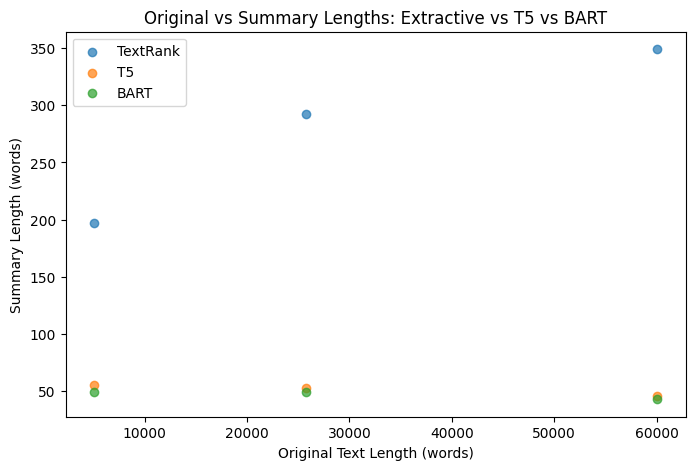

In [54]:
grouped_df['bart_summary_length'] = grouped_df['bart_summary'].apply(lambda x: len(x.split()))

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.scatter(grouped_df['orig_length'], grouped_df['summary_length'], label='TextRank', alpha=0.7)
plt.scatter(grouped_df['orig_length'], grouped_df['t5_summary_length'], label='T5', alpha=0.7)
plt.scatter(grouped_df['orig_length'], grouped_df['bart_summary_length'], label='BART', alpha=0.7)
plt.xlabel('Original Text Length (words)')
plt.ylabel('Summary Length (words)')
plt.title('Original vs Summary Lengths: Extractive vs T5 vs BART')
plt.legend()
plt.show()


1. All summaries are much shorter than the original
The original Q&A groups are huge, but all summaries (TextRank, T5, BART) are tiny in comparison.

2. BART and T5 are very similar in length
Both BART and T5 produce highly compressed, consistently short summaries (typically between 40 and 55 words for your settings).

3. TextRank is longer
TextRank (blue) summaries are much longer than those from BART/T5—this is because it extracts whole sentences (which can be verbose), while BART/T5 generate new text of controlled length.


Abstractive models (T5, BART) are very good at condensing information and provide consistent summary length.

Extractive models (TextRank) vary more and can result in long or awkward summaries, especially on verbose transcripts.


##  Evaluating summary quality - ROUGE

In [55]:
!pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=d54781a5462685496284e628bbfc1bc25ed2950591a511677a48396e54c9e005
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [56]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def get_rouge_scores(summary, reference):
    scores = scorer.score(reference, summary)
    return {k: v.fmeasure for k, v in scores.items()}

# Example: Compare T5 and TextRank
grouped_df['rouge_t5_vs_textrank'] = grouped_df.apply(lambda row: get_rouge_scores(row['t5_summary'], row['summary']), axis=1)
# Example: Compare BART and TextRank
grouped_df['rouge_bart_vs_textrank'] = grouped_df.apply(lambda row: get_rouge_scores(row['bart_summary'], row['summary']), axis=1)

# To see average ROUGE scores:
import numpy as np
rouge_keys = ['rouge1', 'rouge2', 'rougeL']
for method in ['rouge_t5_vs_textrank', 'rouge_bart_vs_textrank']:
    print(f"\nAverage {method} scores:")
    for key in rouge_keys:
        vals = [x[key] for x in grouped_df[method]]
        print(f"{key}: {np.mean(vals):.3f}")



Average rouge_t5_vs_textrank scores:
rouge1: 0.134
rouge2: 0.021
rougeL: 0.077

Average rouge_bart_vs_textrank scores:
rouge1: 0.139
rouge2: 0.012
rougeL: 0.080



ROUGE-1: Overlap of single words (unigrams).

ROUGE-2: Overlap of two-word phrases (bigrams).

ROUGE-L: Overlap in the longest common sequence (sentence structure/order).

Observations:
All scores are low (<0.15),
This is typical when comparing abstractive summaries to extractive summaries.

BART and T5 are very close in ROUGE performance—BART has slightly higher ROUGE-1 and ROUGE-L, but slightly lower ROUGE-2.

ROUGE-2 is especially low (0.012–0.021), showing very little overlap of phrases—again, typical for abstractive models that rephrase instead of copy.

Summary
Abstractive models are working as intended: they create concise, reworded summaries with little overlap to extractive methods.

BART and T5 are both strong—choose based on qualitative readability for the specific context.



# Q&A Text Analysis Findings

Q&A transcripts are detailed and lengthy, making them challenging for quick review or actionable insights.

Extractive summarization (TextRank) condenses the content, but the summaries still contain complex and jargon-heavy sentences, making them only slightly more accessible than the originals.

Abstractive summarization (T5, BART) is highly effective, transforming each lengthy session into a short, readable, and focused summary—typically just a few sentences that capture the core message or financial insight.

Both T5 and BART produce consistently concise summaries, regardless of the original text length, and their summaries are well-suited for executive consumption, dashboards, or automated reporting.

Plots and statistics show an extreme compression effect: The data shrinks from thousands of words to under 60 words per summary, without losing key meaning.

ROUGE analysis confirms that abstractive summaries genuinely condensing information, providing unique value over extractive methods.

